# ML Task 2.4 - Evaluating hyperparameters - Random Forests

## Table of Contents

#### 01. Import libraries and datasets

#### 02. Data preprocessing

#### 03. More imports, train/test data split, Random Search hyperparameter tuning, run best RF model, plot feature importances, decision trees, confusion matrix

#### 04. Results, interpretation

### 01. Import libraries and datasets

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import operator
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn import datasets  
from sklearn.ensemble import RandomForestClassifier
from numpy import argmax
from sklearn.model_selection import train_test_split
from sklearn import metrics  
from sklearn.tree import plot_tree
from sklearn import tree
from sklearn.metrics import accuracy_score

In [3]:
# Create path to dataset location
path = r'C:\Users\dirk8\CareerFoundry\07-2025 Machine Learning With Python\Datasets\Unsupervised'

In [17]:
# Import unscaled weather dataset and Pleasant Weather answers dataset, respectively, without the index column
df_unscaled_2001_2010 = pd.read_excel(os.path.join(path, 'cleaned_weather_unscaled_2001_2010_no_date.xlsx'), index_col=None)
pleas_ans_2001_2010 = pd.read_csv(os.path.join(path, 'pleasant_ans_2001_2010_no_date.csv'), index_col=None)
pleas_ans = pd.read_excel(os.path.join(path, 'answers_pleasant_weather_no_date.xlsx'), index_col=None)
df_unscaled = pd.read_excel(os.path.join(path, 'cleaned_weather_data_task_2.2.xlsx'), index_col=None)

### 02. Data preprocessing

#### Comment: The unscaled weather dataset uploaded here was already preprocessed in the Excel file as follows: (i) 'DATE' and 'MONTH' columns were dropped as we only need numerical data for the Random Forests model inputs -- prior to dropping the columns, the period 2001-01-01 to 2010-12-31 (10 years) was selected for the first part of the Random Forests exercise; (ii) Roma, Gdansk & Tours weather stations and all their associated weather features (columns) were dropped; (iii) the 'snow_depth' (only 6 weather stations had this feature) and 'wind_speed' (only 9 weather stations had this feature) weather features (columns) were dropped from ALL weather stations, to ensure that we have an identical (and in the exact same sequence) set of nine (9) weather features per weather station; (iv) 'cloud_cover' weather feature was only missing for Kassel weather station, so Dusseldorf (229 km away, similar latitude) weather station's data series for that feature was copied to Kassel; (v) 'pressure' weather feature was only missing for MunchenB weather station, so Basel (which has a closer latitude to Munich than Sonnblick does, and a 260-metre elevation versus Sonnblick's 3,100 metres) weather station's data series for that feature was copied to MunchenB; and (vi) 'humidity' weather feature was only missing for Stockholm weather station, so Oslo (similar latitude, also a coastal city) weather station's data series for that feature was copied to Stockholm.

#### Meanwhile, in the Pleasant weather answers dataset uploaded here, the 'DATE' column was dropped as it is not needed for the Random Forests model runs in this exercise; however, prior to dropping that column the period 2001-01-01 to 2010-12-31 (10 years) was selected for the first part of the Random Forests exercise.

#### Data accuracy problem workaround: Kassel and Valentia weather stations, which Task 2.4 requires be included in the weather dataset for Random Forests modeling-based binary classification prediction, unfortunately have inaccurate data (frozen, pardon the pun, at fixed constant values) for most or all of their weather variables over the final 9-12.9 years of the dataset, representing ~ 14.3% (Kassel, 9 years of bad data) and ~ 18.7-19.8% (Valentia, 11.8-12.9 years of bad data) of their 62+ year temporal range of time series data.  Workaround: the first part of Task 2.4 requires model run(s) on a subset decade of data, thus 2001-2010 was the decade selected for model input, to avoid the 9-12+ years of bad data present later at Kassel and Valentia weather stations, which together represent >13% of the 15 weather stations (by station count and proportion of weather data values).

In [19]:
# Check dimensions
print(df_unscaled.shape)
print(pleas_ans.shape)
print(df_unscaled_2001_2010.shape)
print(pleas_ans_2001_2010.shape)

(22950, 135)
(22950, 15)
(3652, 135)
(3652, 15)


In [21]:
# Check a few lines of the weather dataset
df_unscaled.head(2)

,BASEL_cloud_cover,BASEL_humidity,BASEL_pressure,BASEL_global_radiation,BASEL_precipitation,BASEL_sunshine,BASEL_temp_mean,BASEL_temp_min,BASEL_temp_max,BELGRADE_cloud_cover,...,STOCKHOLM_temp_max,VALENTIA_cloud_cover,VALENTIA_humidity,VALENTIA_pressure,VALENTIA_global_radiation,VALENTIA_precipitation,VALENTIA_sunshine,VALENTIA_temp_mean,VALENTIA_temp_min,VALENTIA_temp_max
0,7,0.85,1.018,0.32,0.09,0.7,6.5,0.8,10.9,1,...,4.9,5,0.88,1.0003,0.45,0.34,4.7,8.5,6.0,10.9
1,6,0.84,1.018,0.36,1.05,1.1,6.1,3.3,10.1,6,...,5.0,7,0.91,1.0007,0.25,0.84,0.7,8.9,5.6,12.1


In [23]:
# Check a few lines of the Pleasant weather answers dataset
pleas_ans.head(2)

,BASEL_pleasant_weather,BELGRADE_pleasant_weather,BUDAPEST_pleasant_weather,DEBILT_pleasant_weather,DUSSELDORF_pleasant_weather,HEATHROW_pleasant_weather,KASSEL_pleasant_weather,LJUBLJANA_pleasant_weather,MAASTRICHT_pleasant_weather,MADRID_pleasant_weather,MUNCHENB_pleasant_weather,OSLO_pleasant_weather,SONNBLICK_pleasant_weather,STOCKHOLM_pleasant_weather,VALENTIA_pleasant_weather
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [25]:
# Check for missing data in the weather dataset
df_unscaled.isnull().sum().sum()

0

In [27]:
# Check for missing data in the Pleasant weather answers dataset
pleas_ans.isnull().sum().sum()

0

### 03. More imports, train/test data split, Random Search hyperparameter tuning, run best RF model, plot feature importances, decision trees, confusion matrix

#### Task 2.4 part 1 pursues hyperparameter tuning of the Random Forests model to explore tuning behaviors and compare model performance with the Task 2.3 (Random Forests) non-optimized RF results, globally and locally as follows:

#### Random SearchCV hyperparameter tuning (Scenario A: 135-station features, Madrid target, 2001–2010, unscaled data).

#### Random SearchCV hyperparameter tuning (Scenario B: Madrid 9 features, 1960-2022 (Oct 31), unscaled data).

#### Output evaluation metrics and feature importance plots for both scenarios.

#### Output one decision tree plotted from each fitted RF model.

#### The script below addresses these tasks, using a Random Search method for hyperparameter tuning.

Fitting 3 folds for each of 30 candidates, totalling 90 fits

🎯 Best Hyperparameters (135 Features):
{'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 20, 'criterion': 'gini', 'bootstrap': False}

📊 Evaluation Metrics (135 Features):
Accuracy: 0.9945235487404163
Balanced Accuracy: 0.9942238964551338
F1 Score (Weighted): 0.994522040355002
Recall (Pleasant): 0.9904761904761905
Precision (Pleasant): 0.9976019184652278


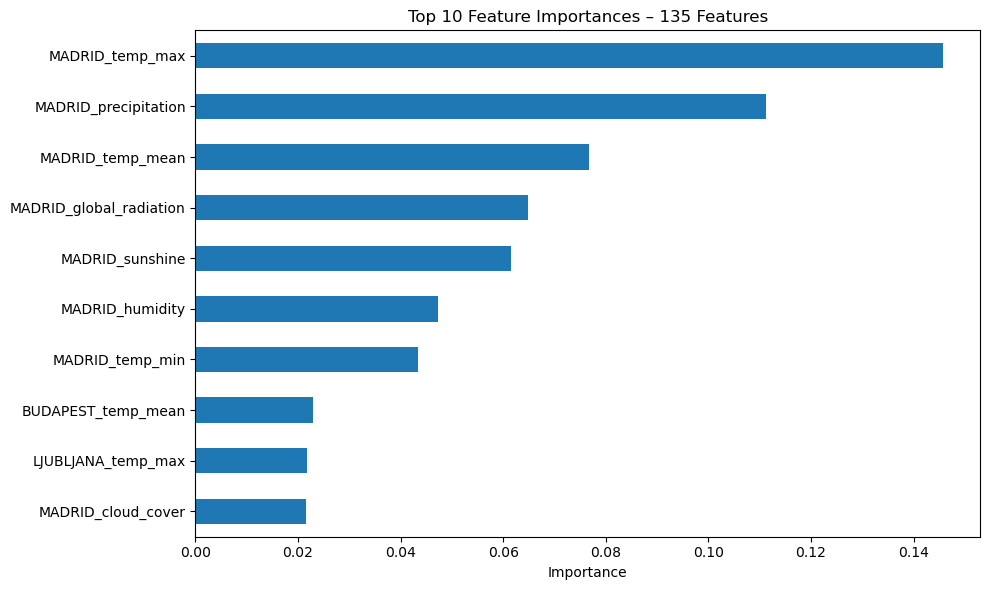

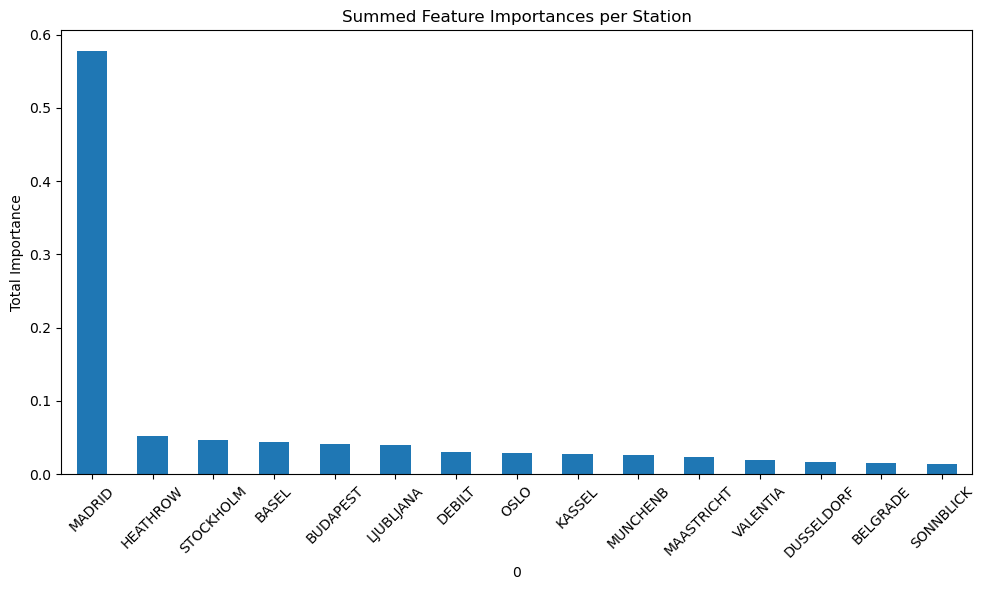

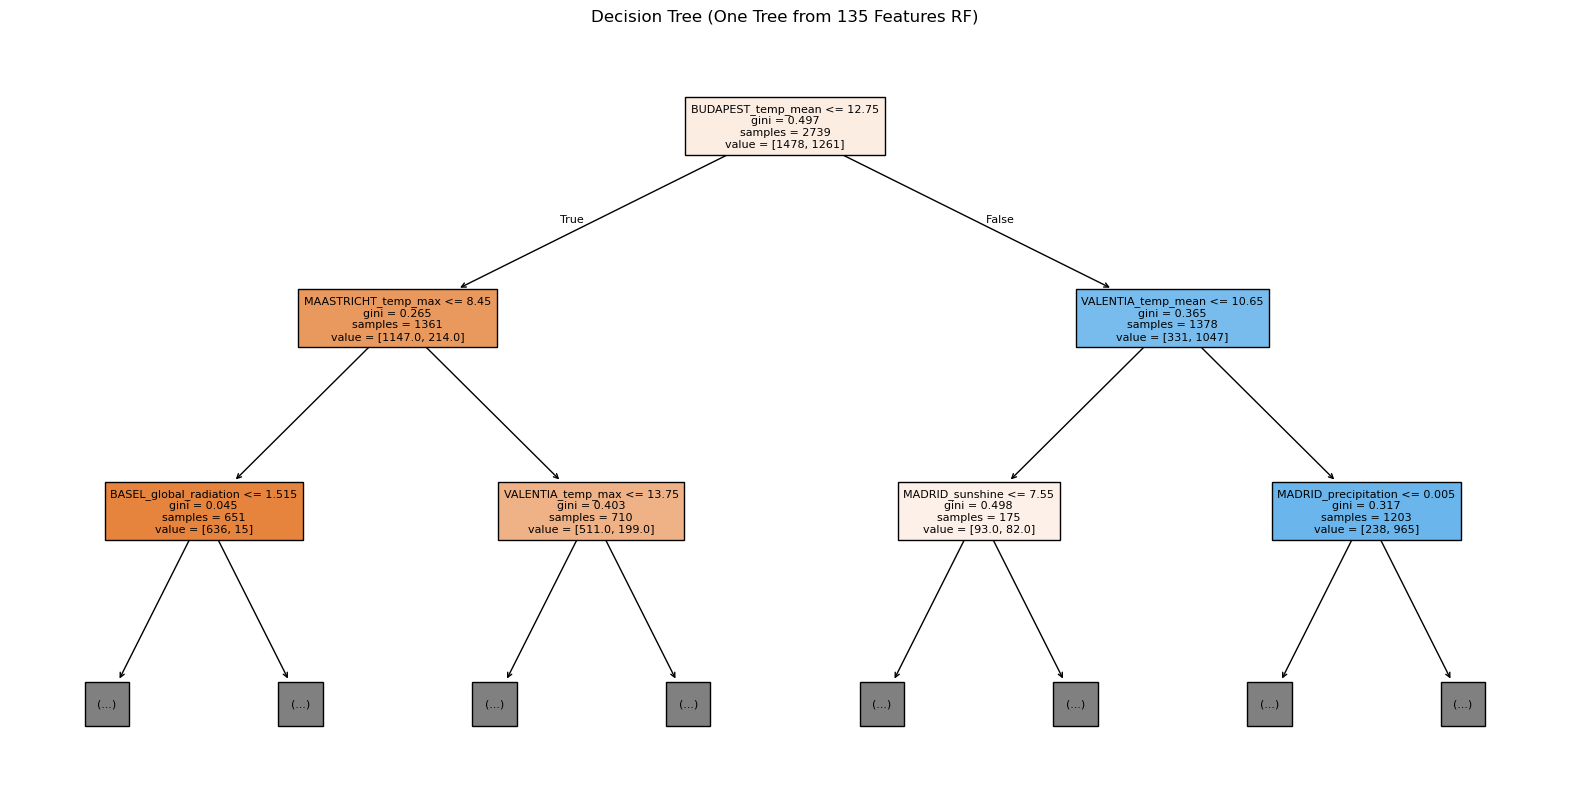

Fitting 3 folds for each of 30 candidates, totalling 90 fits

🎯 Best Hyperparameters (Madrid Only):
{'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 20, 'criterion': 'entropy', 'bootstrap': True}

📊 Evaluation Metrics (Madrid Only):
Accuracy: 1.0
Balanced Accuracy: 1.0
F1 Score (Weighted): 1.0
Recall (Pleasant): 1.0
Precision (Pleasant): 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3176
           1       1.00      1.00      1.00      2562

    accuracy                           1.00      5738
   macro avg       1.00      1.00      1.00      5738
weighted avg       1.00      1.00      1.00      5738



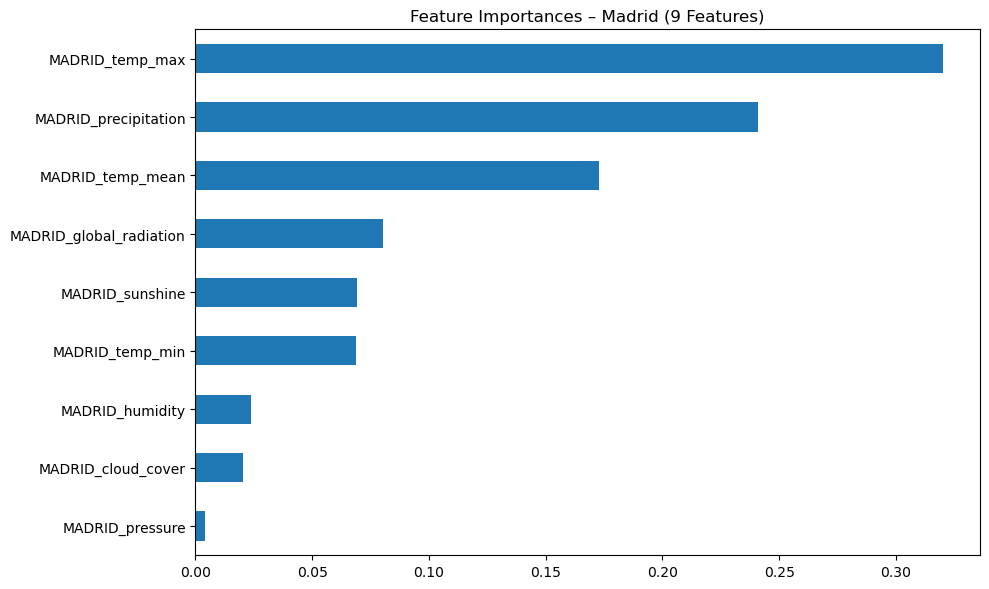

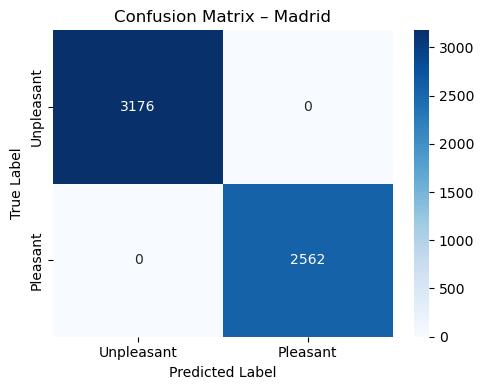

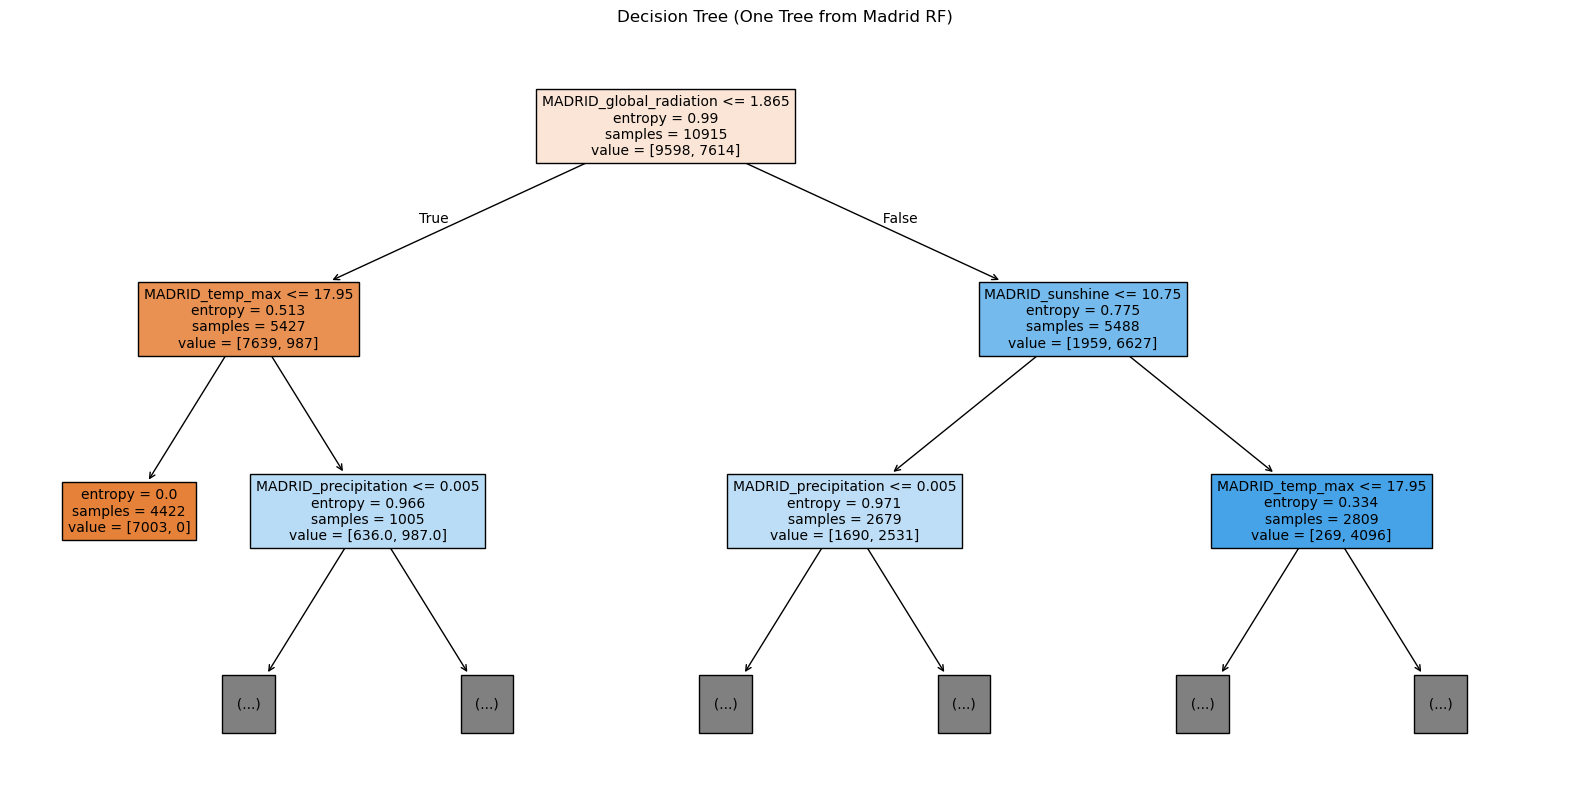


✅ Total Runtime: 0.95 minutes


In [29]:
# -----------------------------------
# 📦 1. Imports and Setup
# -----------------------------------
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, f1_score, precision_score,
    recall_score, confusion_matrix, classification_report
)
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
warnings.filterwarnings("ignore")

# Set display options
pd.set_option("display.max_columns", 150)
random_state = 42

# -----------------------------------
# 📂 2. Load DataFrames
# -----------------------------------
# Assumes `df_unscaled`, 'df_unscaled_2001_2010', 'pleas_ans_2001_2010' and `pleas_ans` are already loaded into memory
assert isinstance(df_unscaled, pd.DataFrame)
assert isinstance(pleas_ans, pd.DataFrame)
assert isinstance(df_unscaled_2001_2010, pd.DataFrame)
assert isinstance(pleas_ans_2001_2010, pd.DataFrame)

# -----------------------------------
# ⏱️ 3. Timer Start
# -----------------------------------
start_time = time.time()

# -----------------------------------
# 🧪 4. Scenario A: 135 Features (All Stations), 2001–2010, Madrid Labels
# -----------------------------------
# Use the 2001–2010 subset dataframes

X_135 = df_unscaled_2001_2010.copy()
y_madrid = pleas_ans_2001_2010['MADRID_pleasant_weather']

# Split into train/test sets
X_train_135, X_test_135, y_train_135, y_test_135 = train_test_split(
    X_135, y_madrid, test_size=0.25, random_state=random_state, stratify=y_madrid
)

# Random Search hyperparameter grid
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy']
}

# Initialize and run Random Search
rf = RandomForestClassifier(random_state=random_state)
random_search_135 = RandomizedSearchCV(
    estimator=rf, param_distributions=rf_params, n_iter=30,
    cv=3, verbose=1, random_state=random_state, n_jobs=-1
)
random_search_135.fit(X_train_135, y_train_135)

# Best model from search
best_rf_135 = random_search_135.best_estimator_
print("\n🎯 Best Hyperparameters (135 Features):")
print(random_search_135.best_params_)

# Predict and evaluate
y_pred_135 = best_rf_135.predict(X_test_135)
print("\n📊 Evaluation Metrics (135 Features):")
print("Accuracy:", accuracy_score(y_test_135, y_pred_135))
print("Balanced Accuracy:", balanced_accuracy_score(y_test_135, y_pred_135))
print("F1 Score (Weighted):", f1_score(y_test_135, y_pred_135, average='weighted'))
print("Recall (Pleasant):", recall_score(y_test_135, y_pred_135, pos_label=1))
print("Precision (Pleasant):", precision_score(y_test_135, y_pred_135, pos_label=1))

# Top 10 feature importances (135 features)
importances_135 = pd.Series(best_rf_135.feature_importances_, index=X_135.columns)
top10 = importances_135.sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
top10.plot(kind='barh')
plt.gca().invert_yaxis()
plt.title("Top 10 Feature Importances – 135 Features")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

# Summed importance by station
station_importance = importances_135.copy()
station_importance.index = station_importance.index.str.extract(r'([A-Z]+)_')[0]
station_importance = station_importance.groupby(station_importance.index).sum().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
station_importance.plot(kind='bar')
plt.title("Summed Feature Importances per Station")
plt.ylabel("Total Importance")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Decision Tree plot (135 features)
plt.figure(figsize=(20, 10))
plot_tree(best_rf_135.estimators_[0], feature_names=X_135.columns, max_depth=2, filled=True, fontsize=8)
plt.title("Decision Tree (One Tree from 135 Features RF)")
plt.show()


# -----------------------------------
# 🧪 5. Scenario B: Madrid Station Only (9 Features), Full Data
# -----------------------------------
madrid_features = [col for col in df_unscaled.columns if col.startswith("MADRID_")]
X_madrid = df_unscaled[madrid_features].copy()
y_madrid_full = pleas_ans['MADRID_pleasant_weather']

# Train/test split
X_train_mad, X_test_mad, y_train_mad, y_test_mad = train_test_split(
    X_madrid, y_madrid_full, test_size=0.25, random_state=random_state, stratify=y_madrid_full
)

# Random Search again
random_search_madrid = RandomizedSearchCV(
    estimator=rf, param_distributions=rf_params, n_iter=30,
    cv=3, verbose=1, random_state=random_state, n_jobs=-1
)
random_search_madrid.fit(X_train_mad, y_train_mad)

# Best model and evaluation
best_rf_mad = random_search_madrid.best_estimator_
print("\n🎯 Best Hyperparameters (Madrid Only):")
print(random_search_madrid.best_params_)

y_pred_mad = best_rf_mad.predict(X_test_mad)
print("\n📊 Evaluation Metrics (Madrid Only):")
print("Accuracy:", accuracy_score(y_test_mad, y_pred_mad))
print("Balanced Accuracy:", balanced_accuracy_score(y_test_mad, y_pred_mad))
print("F1 Score (Weighted):", f1_score(y_test_mad, y_pred_mad, average='weighted'))
print("Recall (Pleasant):", recall_score(y_test_mad, y_pred_mad, pos_label=1))
print("Precision (Pleasant):", precision_score(y_test_mad, y_pred_mad, pos_label=1))
print("\nClassification Report:\n", classification_report(y_test_mad, y_pred_mad))

# Feature importance plot (Madrid)
importances_mad = pd.Series(best_rf_mad.feature_importances_, index=madrid_features)
plt.figure(figsize=(10, 6))
importances_mad.sort_values().plot(kind='barh')
plt.title("Feature Importances – Madrid (9 Features)")
plt.tight_layout()
plt.show()

# Confusion matrix
cm = confusion_matrix(y_test_mad, y_pred_mad)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Unpleasant', 'Pleasant'], yticklabels=['Unpleasant', 'Pleasant'])
plt.title("Confusion Matrix – Madrid")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()

# Decision Tree plot (Madrid)
plt.figure(figsize=(20, 10))
plot_tree(best_rf_mad.estimators_[0], feature_names=madrid_features, max_depth=2, filled=True, fontsize=10)
plt.title("Decision Tree (One Tree from Madrid RF)")
plt.show()

# -----------------------------------
# ⏱️ 6. Runtime
# -----------------------------------
end_time = time.time()
print(f"\n✅ Total Runtime: {(end_time - start_time)/60:.2f} minutes")

#### Plot full decision tree for the 135 station-feature scenario

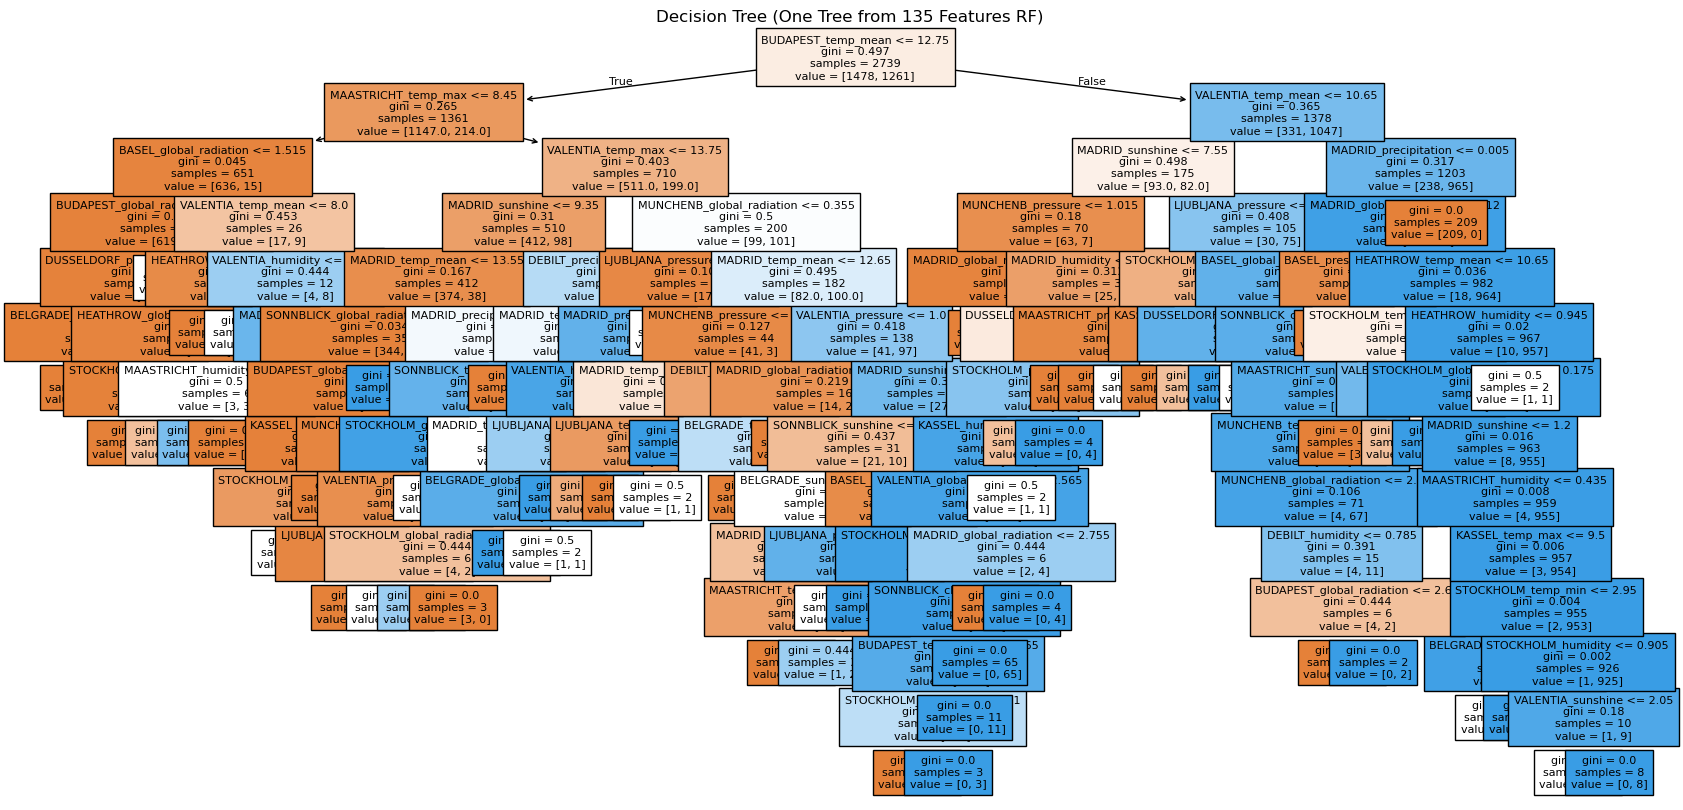

In [32]:
# Decision Tree plot (135 features)
plt.figure(figsize=(20, 10))
plot_tree(best_rf_135.estimators_[0], feature_names=X_135.columns, filled=True, fontsize=8)
plt.title("Decision Tree (One Tree from 135 Features RF)")
plt.show()

#### Plot full decision tree for the Madrid weather station, 9-features scenario

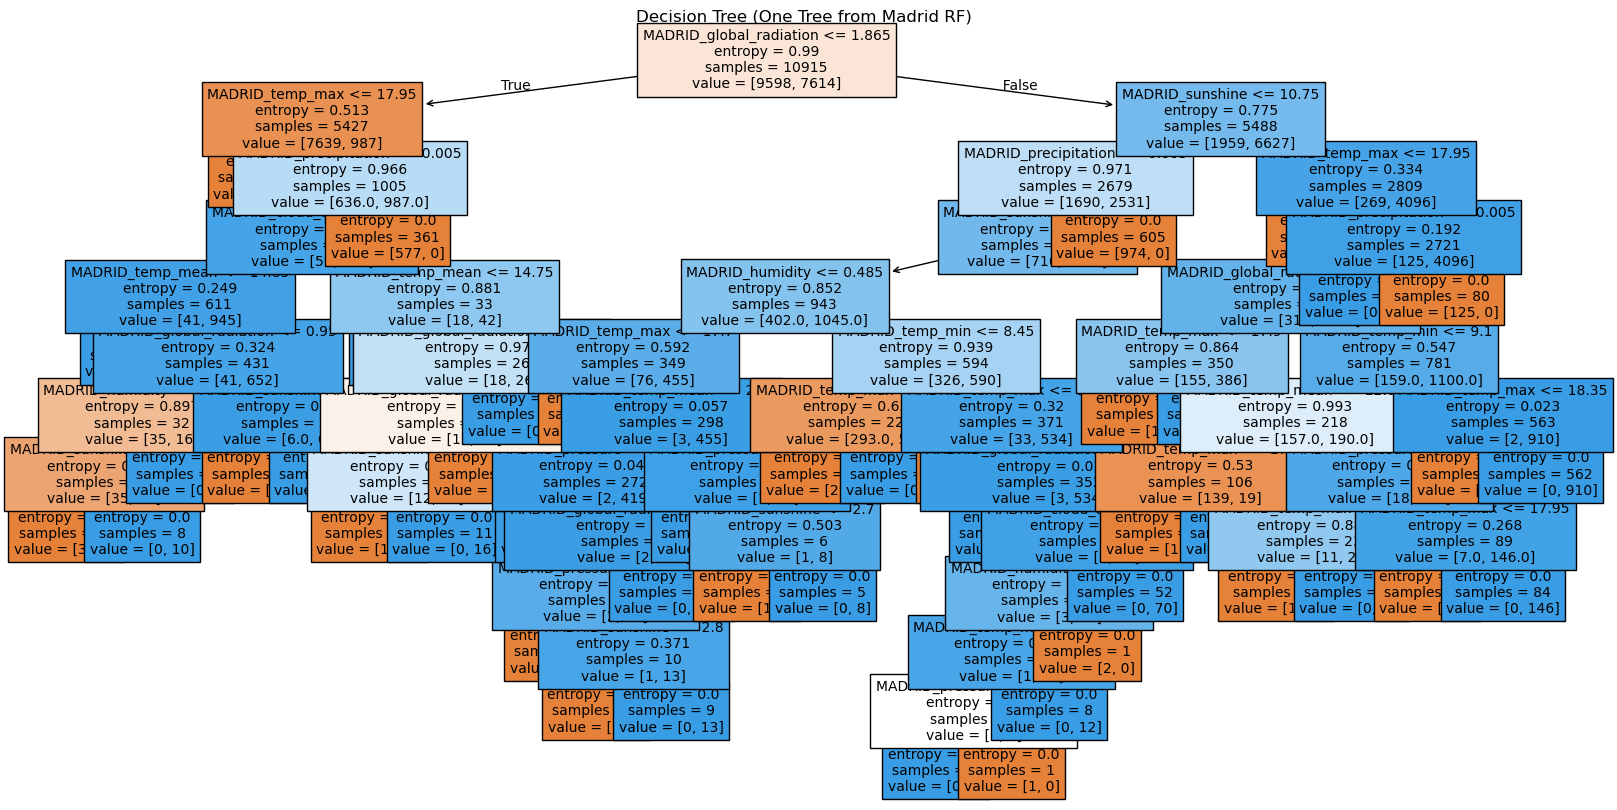

In [35]:
# Decision Tree plot (Madrid)
plt.figure(figsize=(20, 10))
plot_tree(best_rf_mad.estimators_[0], feature_names=madrid_features, filled=True, fontsize=10)
plt.title("Decision Tree (One Tree from Madrid RF)")
plt.show()

### 04. Results, interpretation

#### Results comparison: Tasks 2.3 vs 2.4

### 135 station-features, 2001-2010 decade, unscaled data scenario:
##### Overall Accuracy on Test 99.34% (Task 2.3, non-optimized RF hyperparameters) vs 99.45% (Task 2.4, optimized).
##### Same top 5 station-feature importances, except the 3rd (mean temp) & 5th (sunshine)-ranked importances swapped position.
##### Madrid weather station had the greatest summed feature importances as before, as expected because Madrid again was the y-label selection.
##### Task 2.4-added metrics (Balanced Accuracy, F1 Score (weighted), Recall (Pleasant), Precision (Pleasant) all > 90%.

### Madrid weather station, 9 features, 1960-2022 (Oct 31), unscaled data scenario:
##### Overall Accuracy on Test 100% (Task 2.3, non-optimized RF hyperparameters) vs 100% (Task 2.4, optimized).
##### Two of the top 5 feature importances differed post-optimization (precipitation, max temp now in Top 5, in Task 2.4).
##### Confusion matrix showed perfect Pleasant/Unpleasant predictions as before, but relative counts changed slightly for some (odd) reason.
##### Balanced Accuracy, F1 Score (weighted), Recall (Pleasant), Precision (Pleasant) were all 100% in both Tasks.

#### Interpretation

#### There was no needle to move (improve significantly) from Task 2.3, via the Random Forests hyperparameter optimization conducted in this Task 2.4, because the various performance metrics in 2.3 were already in the 99% - 100% accuracy range.
#### My Occam's Razor-based thesis is that the RF model results in both Tasks (and both scenarios) simply confirm that the undisclosed-provenance, "Black Box" y labels (binary Pleasant/Unpleasant weather answers dataset) provided for model classification prediction exercises were created by deterministic rules & thresholds.  An example of this might be: IF mean temperature > 20 degrees Celsius AND sunshine > (threshold_1 value) AND precipitation < (threshold_2 value) ... AND ... THEN label = Pleasant ELSE label = Unpleasant.

#### The Random Forests model (and Gradient Boosting Machines like XGBoost) excel at reverse-engineering deterministic rules-based labels, which I believe is the case here.  In the prior Task 2.3 individually-fitted station segment, which modeled 6 weather stations independently of each other (using the same 9 weather variables for each), to make collectively 34,428 (5,738 x 6) daily Pleasant or Unpleasant weather predictions for the 6 weather stations, the RF model -- which did not have its hyperparameters optimized at that stage -- achieved 100% perfect predictions.  No misses.

#### A logical sub-thesis might be that if the y labels were created via deterministic rules & thresholds, that these used same-day weather data to decide that day's label outcome (Pleasant or Unpleasant). More succinctly, to decide if today had Pleasant or Unpleasant weather, I use today's weather data (variables) to make that decision.  I would not care about yesterday's weather or prior days, to make a decision about today.

#### Part 2 of Task 2.4 (in a separate notebook script), which applies Bayesian-based hyperparameter tuning to the LSTM model, to compare with Task 2.2 LSTM-derived (non-optimized) results, may shed some light on the same-day data relevance (to y label prediction) sub-thesis.